# Backdoor Defence Pruning

**Moin Mohammad Haroon Khan**<br>
**mk8793** 

# Import the libraries

In [63]:
import tensorflow as tf
from tensorflow import keras
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd
import os

# Load Test and Validation Data and Model

In [24]:
#load Validation data
clean_data_filename_valid = r'C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\data\cl\valid.h5'
backdoored_data_filename_valid = r'C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\data\bd\bd_valid.h5'

#load Test data
clean_data_filename_test = r'C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\data\cl\test.h5'
backdoored_data_filename_test = r'C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\data\bd\bd_test.h5'

#load model
model_filename = r'C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\model\bd_net.h5'

# Function to load data from Hierarchical Data Formats (HDF) (.h5)

In [25]:
# Open the HDF5 file in read mode
def load_data(file_name):
    #read data
    with h5py.File(file_name, 'r') as file:
        #load data
        x = file['data'][:]
        
        #load labels
        y = file['label'][:]

    return x, y

# Analyze the Model and Dataset

In [26]:
#load the model
model = keras.models.load_model(model_filename)

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

The provided neural network architecture consists of the following layers:

**Input Layer**:

Name: input
Shape: (55, 47, 3)
Type: InputLayer

**Convolutional Layers**:

conv_1: 20 filters, kernel size (4, 3), ReLU activation
conv_2: 40 filters, kernel size (3, 3), ReLU activation
conv_3: 60 filters, kernel size (3, 3), ReLU activation
conv_4: 80 filters, kernel size (2, 2), ReLU activation

**Max Pooling Layers:**

pool_1: Pool size (2, 2)
pool_2: Pool size (2, 2)
pool_3: Pool size (2, 2)
Flatten Layers:

flatten_1: Flattens the output of pool_3
flatten_2: Flattens the output of conv_4
Fully Connected (Dense) Layers:

fc_1: 160 units, ReLU activation
fc_2: 160 units, ReLU activation

**Addition Layer:**

add_1: Adds the outputs of fc_1 and fc_2 element-wise
Activation Layer:

activation_1: Applies an activation function to the output of add_1
Output Layer:

**Output**: 
1283 units, representing the final output classes, likely with a softmax activation
This architecture combines convolutional layers for feature extraction, max pooling layers for downsampling, fully connected layers for global patterns, and an output layer for classification. The model appears to be designed for a task with 1283 output classes based on the architecture of the output layer. The specifics of activation functions and additional configuration details are not fully provided.

## Explore the data

In [41]:
#load clean validation data
x_cl_valid, y_cl_valid = load_data(clean_data_filename_valid)

x_cl_valid[0].shape

(3, 55, 47)

In [42]:
#transpose the data from channel * width* height to width* height*channel to 
x_cl_valid = x_cl_valid.transpose((0,2,3,1))
x_cl_valid[0].shape

(55, 47, 3)

In [43]:
y_cl_valid

array([  43.,  328.,  196., ..., 1265.,  845.,  881.])

In [44]:
#load clean validation data

x_bd_valid, y_bd_valid = load_data(backdoored_data_filename_valid)
x_bd_valid = x_bd_valid.transpose((0,2,3,1))

## Display clean data

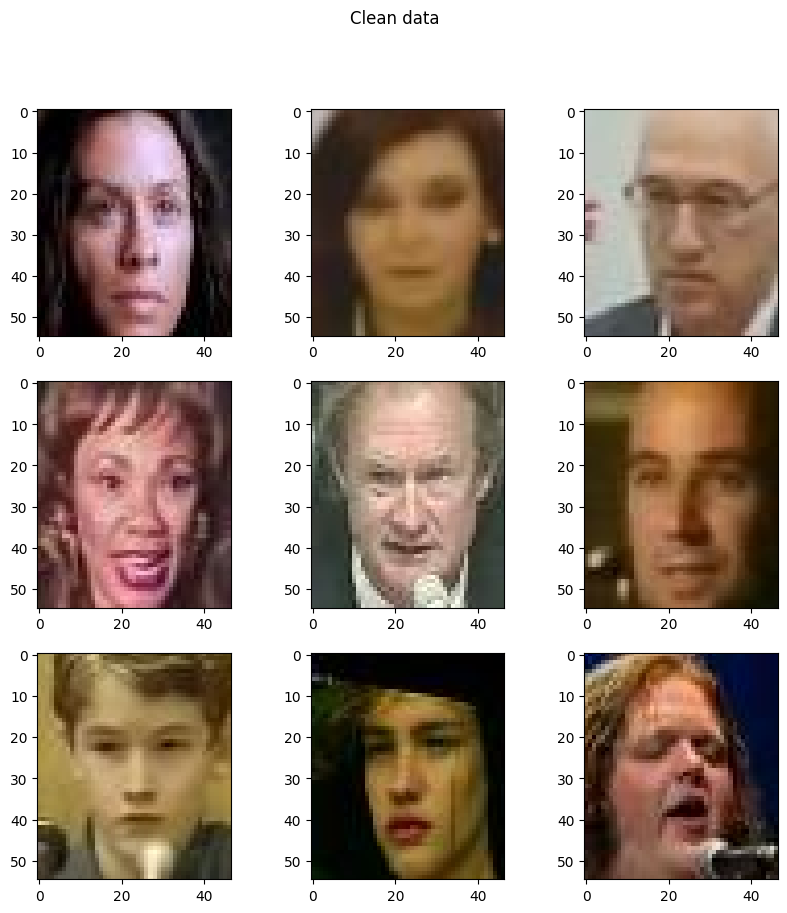

In [67]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate through the subplots and plot the data
cnt = 0
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(x_cl_valid[i*3+j]/255.0) #divide the pixel by 255.0 since plot uses data between 0-1
        cnt +=1

plt.suptitle("Clean data")
plt.show()

## Display Backdoor data

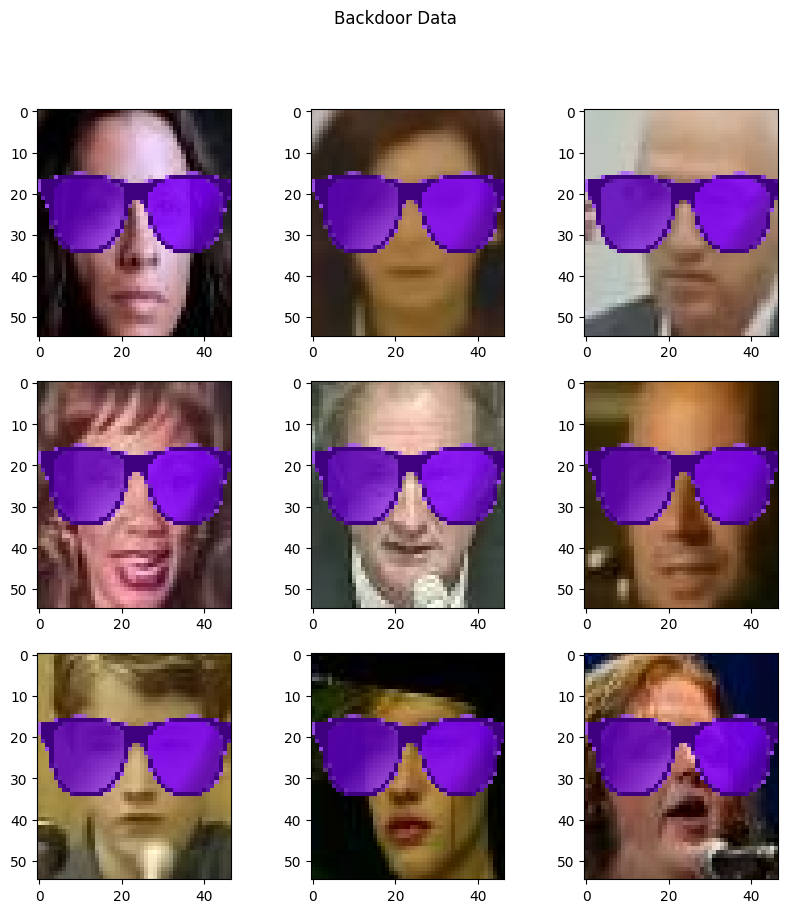

In [66]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Iterate through the subplots and plot the data
cnt = 0
for i in range(3):
    for j in range(3):
        axes[i, j].imshow(x_bd_valid[i*3+j]/255.0) #divide the pixel by 255.0 since plot uses data between 0-1
        cnt +=1
plt.suptitle("Backdoor Data")
plt.show()

# Build Backdoor Repaired model using Defence Pruning 

In Backdoor defence pruning methodology, the purpose to enhance the robustness of machine learning models against backdoor attacks. In this defence method, we pruned the layers which are susceptible to manipulation by backdoor patterns.

Follwing are the steps required to detect backdoor attacks:

- **Evaluation on Backdoor Data:**
    Evaluate the trained model on the backdoor dataset to measure its vulnerability to backdoor attacks.
    Calculate the initial attack success rate, representing the model's accuracy on the backdoor data.<br><br>
  

- **Identify Targeted Layers:**
    Identify layers in the model that are vulnerable to backdoor attacks. These are often layers close to the input where the backdoor pattern has a significant impact.  <br><br>
  
- **Prune Activation Channels:**
    For each identified layer, systematically prune specific activation channels based on predetermined criteria.
    Criteria may involve analyzing activation values to identify and prune channels associated with the backdoor pattern.<br><br>

- **Model Re-evaluation:**
    Re-evaluate the pruned model on both clean and backdoor datasets after each round of pruning.
    Monitor changes in accuracy and attack success rate to assess the impact of pruning on the model's behavior.<br><br>

- **Iterative Pruning:**
    Iterate the pruning process, gradually removing more channels or layers that exhibit characteristics of backdoor activation.
    Continue evaluating the model after each iteration to observe the evolving impact on performance.<br><br>

- **Threshold-based Saving:**
    Set thresholds for accuracy differences between the original model and the pruned model.
    Save the pruned model if the accuracy on clean data drops below a certain threshold, indicating potential backdoor removal.<br><br>

- **Monitor Defense Effectiveness:**
    Continuously monitor the model's defense effectiveness against backdoor attacks.
    Adjust pruning strategies, thresholds, or other parameters based on ongoing evaluations and emerging threat patterns.<br><br>

In our model, the last pooling layer, named "pool_3," comprises a total of 60 channels. Initially, we determine the model accuracy without any pruning. Next, we calculate the average activation value for each channel in the "pool_3" layer. Subsequently, we iterate over the channels in ascending order of their average activations, progressively pruning the model by setting the corresponding weights and biases of previous convolutional layer "conv_3" to zero. This step-by-step process ensures a systematic approach to channel pruning based on their individual contributions to the model's performance.

In [68]:
class PrunedModel:
    def __init__(self, model_path):
        """
        Initialize the PrunedModel with a pre-trained model.

        Parameters:
        - model_path (str): Path to the pre-trained model.
        """
        self.base_model = keras.models.load_model(model_path)

    def call(self, clean_data_filename, bd_data_filename, threshold=[2, 4, 10], save_model_path=None):
        """
        Perform the backdoor pruning defense.

        Parameters:
        - clean_data_filename (str): File path for clean data.
        - bd_data_filename (str): File path for backdoor data.
        - threshold (list): List of threshold values for model accuracy drop.
        - save_model_path (str): Path to save pruned models.

        Returns:
        - accuracy (list): List of model accuracies during the pruning process.
        - attack_success_rate (list): List of attack success rates during the pruning process.
        - def_model_path (dict): Dictionary containing paths to saved models based on thresholds.
        """
        accuracy = []
        attack_success_rate = []
        def_model_path = {}

        # Load Clean Data
        print("Load Clean Data")
        X_cl, Y_cl = load_data(clean_data_filename)

        # Load Backdoor Data
        print("Load Backdoor Data")
        X_bd, Y_bd = load_data(bd_data_filename)

        # Reshape datasets since the model expects input shape (55, 47, 3)
        X_cl = X_cl.transpose((0, 2, 3, 1))
        X_bd = X_bd.transpose((0, 2, 3, 1))

        # Prune the specified layer during training

        # Calculate Model accuracy on clean data
        print(f"Calculate Model accuracy on clean data")
        inital_model_accuracy = accuracy_score(self.base_model.predict(X_cl).argmax(axis=1), Y_cl) * 100

        # Calculate Model accuracy on Backdoor data
        print(f"Calculate Model accuracy on Backdoor data")
        attack_success = accuracy_score(self.base_model.predict(X_bd).argmax(axis=1), Y_bd) * 100

        print(f"Model accuracy (Clean Data) initially : {inital_model_accuracy}")
        print(f"Attack Success Rate initially : {attack_success}")

        accuracy.append(inital_model_accuracy)
        attack_success_rate.append(attack_success)

        # Get the output after the last pooling layer ("pool_3")
        last_pooling_layer_output = self.base_model.get_layer('pool_3').output
        intermediate_model = keras.models.Model(inputs=self.base_model.inputs, outputs=last_pooling_layer_output)

        # Get average activation value of each channel in the last pooling layer ("pool_3")
        avg_activations = intermediate_model.predict(X_cl).mean(axis=(0, 1, 2))

        # Save the index to prune in sorted order
        idx_prune = np.argsort(avg_activations)

        # Get weights and biases of conv3
        weights = intermediate_model.get_layer('conv_3').get_weights()[0]
        biases = intermediate_model.get_layer('conv_3').get_weights()[1]

        i = 0
        print("Start pruning")

        # Iterate through channels
        for idx in idx_prune:
            print(f"\nCurrent Channel Index: {idx}")

            # Prune the channel
            weights[:, :, :, idx] = 0
            biases[idx] = 0

            # Prune the layer by updating the base_model's weights and biases
            self.base_model.get_layer('conv_3').set_weights([weights, biases])

            # Calculate the accuracy of the model now after pruning
            model_accuracy_cl_data = accuracy_score(self.base_model.predict(X_cl).argmax(axis=1), Y_cl) * 100
            model_accuracy_bd_data = accuracy_score(self.base_model.predict(X_bd).argmax(axis=1), Y_bd) * 100

            accuracy.append(model_accuracy_cl_data)
            attack_success_rate.append(model_accuracy_bd_data)

            print(f"Model accuracy (Clean Data) for channel index {idx} : {model_accuracy_cl_data}%")
            print(f"Attack Success Rate for channel index {idx} : {model_accuracy_bd_data}%")

            # Save the pruned model if accuracy drops below specified thresholds
            if i < len(threshold) and inital_model_accuracy - model_accuracy_cl_data >= threshold[i]:
                def_model_name = os.path.join(save_model_path or os.getcwd(), f"model_bd_x_thres_{threshold[i]}")

                print(f"Model Accuracy differ by {threshold[i]}")
                self.base_model.save(def_model_name)
                print(f"Saved model for {threshold[i]}% at {def_model_name}")
                def_model_path[threshold[i]] = def_model_name

                i += 1

            #clear keras session, to release memory
            keras.backend.clear_session()

        return accuracy, attack_success_rate, def_model_path


Run defence pruning on our model for thresholds [2, 4, 10]

In [69]:
pruned_model = PrunedModel(model_filename)

accuracy, attack_success_rate, def_model_path = pruned_model.call(clean_data_filename_valid, backdoored_data_filename_valid, save_model_path=r"C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3")

Load Clean Data
Load Backdoor Data
Calculate Model accuracy on clean data
361/361 [==============================] - 2s 4ms/step
Calculate Model accuracy on Backdoor data
361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) initially : 98.64899974019225
Attack Success Rate initially : 100.0
361/361 [==============================] - 1s 3ms/step
Start pruning

Current Channel Index: 0
361/361 [==============================] - 2s 4ms/step
Model accuracy (Clean Data) for channel index 0 : 98.64899974019225%
Attack Success Rate for channel index 0 : 100.0%

Current Channel Index: 26
361/361 [==============================] - 2s 4ms/step
Model accuracy (Clean Data) for channel index 26 : 98.64899974019225%
Attack Success Rate for channel index 26 : 100.0%

Current Channel Index: 27
361/361 [==============================] - 2s 4ms/step
Model accuracy (Clean Data) for channel index 27 : 98.64899974019225%
Attack Success Rate for channel index 27 : 100.0%

Curre

361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) for channel index 15 : 98.64899974019225%
Attack Success Rate for channel index 15 : 100.0%

Current Channel Index: 23
361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) for channel index 23 : 98.64899974019225%
Attack Success Rate for channel index 23 : 100.0%

Current Channel Index: 6
361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) for channel index 6 : 98.64899974019225%
Attack Success Rate for channel index 6 : 100.0%

Current Channel Index: 51
361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) for channel index 51 : 98.64033948211657%
Attack Success Rate for channel index 51 : 100.0%

Current Channel Index: 32
361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) for channel index 32 : 98.64033948211657%
Attack Success Rate for channel index 32 : 100.0%

Current Channel Ind

INFO:tensorflow:Assets written to: C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\model_bd_x_thres_2\assets


Saved model for 2% at C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\model_bd_x_thres_2

Current Channel Index: 16
361/361 [==============================] - 2s 4ms/step
Model accuracy (Clean Data) for channel index 16 : 95.20221702606739%
Attack Success Rate for channel index 16 : 99.9913397419243%

Current Channel Index: 56
361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) for channel index 56 : 94.7172425738287%
Attack Success Rate for channel index 56 : 99.9913397419243%

Current Channel Index: 46
361/361 [==============================] - 2s 4ms/step
Model accuracy (Clean Data) for channel index 46 : 92.09318437689443%
Attack Success Rate for channel index 46 : 99.9913397419243%
Model Accuracy differ by 4
INFO:tensorflow:Assets written to: C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\model_bd_x_thres_4\assets


INFO:tensorflow:Assets written to: C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\model_bd_x_thres_4\assets


Saved model for 4% at C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\model_bd_x_thres_4

Current Channel Index: 5
361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) for channel index 5 : 91.49562656967177%
Attack Success Rate for channel index 5 : 99.9913397419243%

Current Channel Index: 8
361/361 [==============================] - 2s 4ms/step
Model accuracy (Clean Data) for channel index 8 : 91.01931237550879%
Attack Success Rate for channel index 8 : 99.98267948384861%

Current Channel Index: 11
361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) for channel index 11 : 89.17467740538669%
Attack Success Rate for channel index 11 : 80.73958603966398%

Current Channel Index: 54
361/361 [==============================] - 2s 4ms/step
Model accuracy (Clean Data) for channel index 54 : 84.43751623798389%
Attack Success Rate for channel index 54 : 77.015675067117%
Model Accuracy differ by 10
INFO:tensorflow:Assets 

INFO:tensorflow:Assets written to: C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\model_bd_x_thres_10\assets


Saved model for 10% at C:\Users\moink\Downloads\MLCS\lab3-20231122T074643Z-001\lab3\model_bd_x_thres_10

Current Channel Index: 10
361/361 [==============================] - 2s 4ms/step
Model accuracy (Clean Data) for channel index 10 : 76.48739932449988%
Attack Success Rate for channel index 10 : 35.71490430414826%

Current Channel Index: 28
361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) for channel index 28 : 54.8627349095003%
Attack Success Rate for channel index 28 : 6.954187234779596%

Current Channel Index: 35
361/361 [==============================] - 2s 4ms/step
Model accuracy (Clean Data) for channel index 35 : 27.08928726076037%
Attack Success Rate for channel index 35 : 0.4243526457088421%

Current Channel Index: 18
361/361 [==============================] - 1s 4ms/step
Model accuracy (Clean Data) for channel index 18 : 13.87373343725643%
Attack Success Rate for channel index 18 : 0.0%

Current Channel Index: 4
361/361 [===================

## Graph to get model accuracy and attack success rate on validation data for each pruned channel

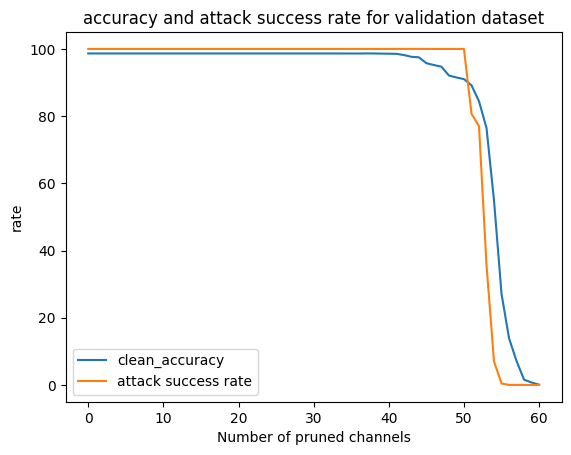

In [73]:
x_axis = range(len(accuracy))
plt.plot(x_axis,accuracy)
plt.plot(x_axis,attack_success_rate)
plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("Number of pruned channels")
plt.ylabel("rate")
plt.title("accuracy and attack success rate for validation dataset")
plt.show()

## Test the accuracy of the repaired backdoore threshold model

In [74]:
test_accuracy = []
attack_rate = []

#load clean and backdoor test data
x_cl_test, y_cl_test = load_data(clean_data_filename_test)
x_bd_test, y_bd_test = load_data(backdoored_data_filename_test)

x_cl_test = x_cl_test.transpose((0, 2,3,1))
x_bd_test = x_bd_test.transpose((0, 2,3,1))

#iterate through each repaired model and find the test accuracy
for threshold, model_path in def_model_path.items():
    print(f"\nRepaired Model Accuracy on Test Data for: {threshold}% drop model")

    #load repaired model
    repaired_model = keras.models.load_model(model_path)

    #get prediction on clean test data
    y_pred_cl = repaired_model.predict(x_cl_test).argmax(axis=1)
    
    #get prediciton on backdoor predicted data
    y_pred_bd = repaired_model.predict(x_bd_test).argmax(axis=1)


    #append accuracy and attack success rate of the model
    test_accuracy.append(round(accuracy_score(y_pred_cl, y_cl_test)*100,3))
    attack_rate.append(round(accuracy_score(y_pred_bd, y_bd_test)*100,3))

    print(f"Test Accuracy: {test_accuracy[-1]}")
    print(f"Attack Success Rate: {attack_rate[-1]}")

#get table of overall perfomrance of the model
df = pd.DataFrame({
    "test_accuracy": test_accuracy,
    "attack_rate": attack_rate,
    "model": [ f"repaired_model_{i}%" for i in def_model_path.keys()]
})

df.set_index('model')


Repaired Model Accuracy on Test Data for: 2% drop model
401/401 [==============================] - 2s 4ms/step
Test Accuracy: 95.9
Attack Success Rate: 100.0

Repaired Model Accuracy on Test Data for: 4% drop model
401/401 [==============================] - 2s 4ms/step
Test Accuracy: 92.292
Attack Success Rate: 99.984

Repaired Model Accuracy on Test Data for: 10% drop model
401/401 [==============================] - 2s 4ms/step
Test Accuracy: 84.544
Attack Success Rate: 77.21


,test_accuracy,attack_rate
model,,
repaired_model_2%,95.900,100.000
repaired_model_4%,92.292,99.984
repaired_model_10%,84.544,77.210


## Graph to get model accuracy and attack success rate on test data for each pruned channel

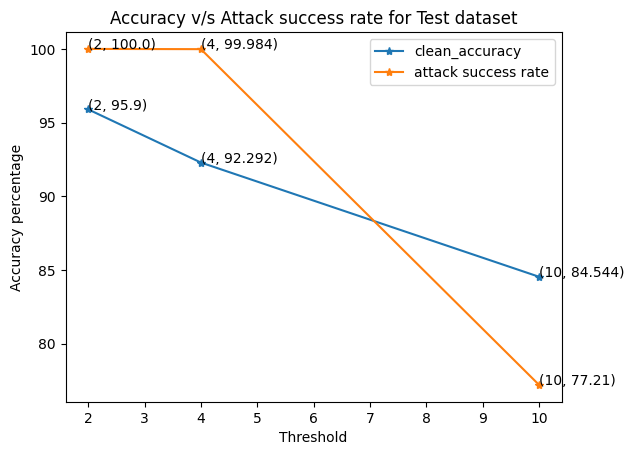

In [75]:
import matplotlib.pyplot as plt

plt.plot(def_model_path.keys(), test_accuracy, marker="*")
for xy in zip(def_model_path.keys(), test_accuracy):                                     
    plt.annotate(xy, xy=xy, textcoords='data')

plt.plot(def_model_path.keys(), attack_rate, marker="*")
for xy in zip(def_model_path.keys(), attack_rate):
    plt.annotate(xy, xy=xy, textcoords='data')


plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("Threshold")
plt.ylabel("Accuracy percentage")
plt.title("Accuracy v/s Attack success rate for Test dataset")
plt.show()

Here we can observe that model has high accuracy and attack success rate for each threshold models, .i.e for 2% drop, model accuracy on clean data is 100% and at the same time model is susceptible to attack for 95% backdoor data. Similar trend is observe for 4% and 10% threshold model  

# GoodNet Model

The goodnet model will be the combination of Bad Net (backdoor Model) and the repaired Backdoor model.

 For each test input, we will run it through both Backdoor Model and Repaired Backdoor Model. If the classification outputs are the same, i.e., class i, goodnet will output class i. If they differ goognet will output N+1 (1284). 

In [76]:
import numpy as np

class G:
    def __init__(self, model_B, model_B_prime):
        """
        Initialize the G class with two models: model_B and model_B_prime.

        Parameters:
        - model_B: Backdoor model.
        - model_B_prime: Repaired backdoor model.
        """
        self.model_B = model_B
        self.model_B_prime = model_B_prime

    def predict(self, data):
        """
        Predict using both the backdoor model (model_B) and the repaired backdoor model (model_B_prime).

        Parameters:
        - data: Input data for prediction.

        Returns:
        - y_pred: Predicted labels with backdoor-affected predictions replaced by 1.
        """
        # Predict using the backdoor model (B)
        print("Predict using backdoor model (B)")
        y_b = self.model_B.predict(data).argmax(axis=1)

        # Predict using the repaired backdoor model (B_prime)
        print("Predict using repaired backdoor model (B_prime)")
        y_b_prime = self.model_B_prime.predict(data).argmax(axis=1)

        # Replace predictions affected by the backdoor with 1
        y_pred = np.where(y_b == y_b_prime, y_b, 1284)

        return np.array(y_pred)


## Evaluate Goodnet model on clean and backdoored (poisoned) test data

In [77]:
test_accuracy = []
attack_rate = []

#load clean and backdoor test data
x_cl_test, y_cl_test = load_data(clean_data_filename_test)
x_bd_test, y_bd_test = load_data(backdoored_data_filename_test)

x_cl_test = x_cl_test.transpose((0, 2,3,1))
x_bd_test = x_bd_test.transpose((0, 2,3,1))


#load backdoor model
backdoor =  keras.models.load_model(model_filename)

#iterate through each repaired model and find the test accuracy
for threshold, model_path in def_model_path.items():
    print(f"Goodnet Model Accuracy on Test Data for: {threshold}% drop model")

    #load repaired model
    repaired_model = keras.models.load_model(model_path)

    #load goodnet model, backdoor_model + repiared_model
    goodnet_model = G(backdoor, repaired_model)

    #predict for clean test data
    y_pred_cl = goodnet_model.predict(x_cl_test)
    
    #predict for backdoored test data
    y_pred_bd = goodnet_model.predict(x_bd_test)

    #save the model accuracy score and attack success rate
    test_accuracy.append(round(accuracy_score(y_pred_cl, y_cl_test)*100,3))
    attack_rate.append(round(accuracy_score(y_pred_bd, y_bd_test)*100, 3))

    print(f"Test Accuracy: {test_accuracy[-1]}")
    print(f"Attack Success Rate: {attack_rate[-1]}\n")


#dataframe to get Goodnet model performance
df = pd.DataFrame({
    "test_accuracy": test_accuracy,
    "attack_rate": attack_rate,
    "model": [ f"repaired_model_{i}%" for i in def_model_path.keys()]
})

df.set_index('model')

Goodnet Model Accuracy on Test Data for: 2% drop model
Predict using backdoor model (B)
401/401 [==============================] - 2s 4ms/step
Predict using repaired backdoor model (B_prime)
401/401 [==============================] - 2s 4ms/step
Predict using backdoor model (B)
401/401 [==============================] - 2s 4ms/step
Predict using repaired backdoor model (B_prime)
401/401 [==============================] - 2s 4ms/step
Test Accuracy: 95.744
Attack Success Rate: 100.0

Goodnet Model Accuracy on Test Data for: 4% drop model
Predict using backdoor model (B)
401/401 [==============================] - 2s 4ms/step
Predict using repaired backdoor model (B_prime)
401/401 [==============================] - 2s 4ms/step
Predict using backdoor model (B)
401/401 [==============================] - 2s 4ms/step
Predict using repaired backdoor model (B_prime)
401/401 [==============================] - 2s 4ms/step
Test Accuracy: 92.128
Attack Success Rate: 99.984

Goodnet Model Accuracy on

,test_accuracy,attack_rate
model,,
repaired_model_2%,95.744,100.000
repaired_model_4%,92.128,99.984
repaired_model_10%,84.334,77.210


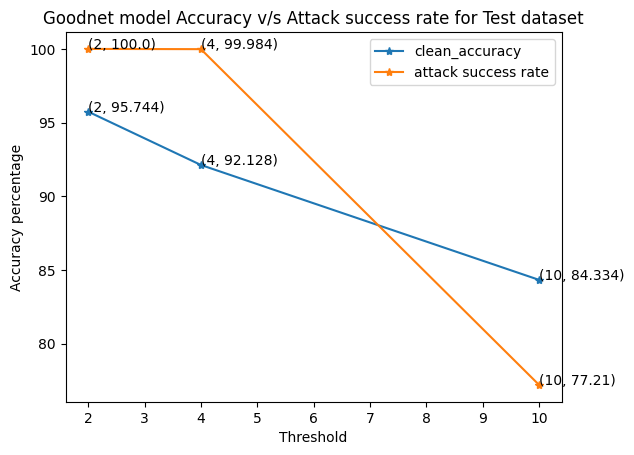

In [78]:
#plot for accuracy
plt.plot(def_model_path.keys(), test_accuracy, marker="*")
for xy in zip(def_model_path.keys(), test_accuracy):                                     
    plt.annotate(xy, xy=xy, textcoords='data')

#plot for attack success rate
plt.plot(def_model_path.keys(), attack_rate, marker="*")
for xy in zip(def_model_path.keys(), attack_rate):
    plt.annotate(xy, xy=xy, textcoords='data')

plt.legend(['clean_accuracy','attack success rate'])
plt.xlabel("Threshold")
plt.ylabel("Accuracy percentage")
plt.title("Goodnet model Accuracy v/s Attack success rate for Test dataset")
plt.show()

Here we observe that the Goodnet model has the same performance as the Badnet repaired model. However, for backdoor input, the goodnet model instead of returning backdoor output the it returns 1284 indicating the input is backdoored.